In [605]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance

In [606]:
#Kernel and sigma list for experimentation
kernel_sizes=[(251,251)]
sigmas=[91]
window_size=128

In [611]:
img1 = cv2.imread('bikes/bikes/img1.ppm')
img1_gray=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
pad_size = window_size // 2
padded_img1_gray = cv2.copyMakeBorder(img1_gray, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REPLICATE)

    
img2 = cv2.imread('bikes/bikes/img2.ppm')
img2_gray=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
padded_img2_gray = cv2.copyMakeBorder(img2_gray, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REPLICATE)

transformation_matrix=np.loadtxt('bikes/bikes/H1to2p')

In [612]:
cell_low_pass_filter_list=[]
def get_conv_filter(filter_type,kernels,standard_deviations,image):
    filter_list=[]
    if filter_type == "Gauss":
        for kernel in kernels:
            for sigma in standard_deviations:
                gauss_smooth_image=cv2.GaussianBlur(image,kernel,sigma)
                filter_list.append(gauss_smooth_image)
        return filter_list
    
def normalize_image(manipulated_image):
   
    min_val = np.min(manipulated_image)
    max_val = np.max(manipulated_image)

    normalized_image = (manipulated_image - min_val) / (max_val - min_val)

    normalized_image = np.clip(normalized_image, 0, 1)

    normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

    return normalized_image_uint8

def compute_color_tensors(derivatives):
    tensor_size = len(derivatives["red"])
    tensor_structure = np.zeros((tensor_size, tensor_size), dtype=object)
    
    for i in range(tensor_size):
        for j in range(tensor_size):
            tensor_product = np.zeros_like(derivatives["red"][0])  # Initialize tensor product
            
            # Iterate over each derivative and compute the tensor product
            for key in derivatives.keys():
                derivative_i = derivatives[key][i]
                derivative_j = derivatives[key][j]
                tensor_product += np.multiply(derivative_i, derivative_j)
            
            # Apply filter and normalization
            filter_list = get_conv_filter("Gauss", kernel_sizes, sigmas, tensor_product)
            tensor_structure[i, j] = np.multiply(np.array(filter_list[0]), tensor_product)
            tensor_structure[i, j] = normalize_image(tensor_structure[i, j])
    
    return tensor_structure

derivatives={}
# Split the image into its RGB channels
b, g, r = cv2.split(img1)

# Compute derivatives along each channel
Ix_b = cv2.Sobel(b, cv2.CV_64F, 1, 0, ksize=3)  
Iy_b = cv2.Sobel(b, cv2.CV_64F, 0, 1, ksize=3) 

Ix_g = cv2.Sobel(g, cv2.CV_64F, 1, 0, ksize=3)  
Iy_g = cv2.Sobel(g, cv2.CV_64F, 0, 1, ksize=3)  

Ix_r = cv2.Sobel(r, cv2.CV_64F, 1, 0, ksize=3)  
Iy_r = cv2.Sobel(r, cv2.CV_64F, 0, 1, ksize=3)  

derivatives["red"] = [Ix_r, Iy_r]
derivatives["green"] = [Ix_g, Iy_g]
derivatives["blue"] = [Ix_b, Iy_b]

Ix=cv2.merge((Ix_b,Ix_g,Ix_r))
Ix=normalize_image(Ix)

Iy=cv2.merge((Iy_b,Iy_g,Iy_r))
Iy=normalize_image(Iy)

Ix_b=normalize_image(Ix_b)
Iy_b=normalize_image(Iy_b)

Ix_g=normalize_image(Ix_g)
Iy_g=normalize_image(Iy_g)

Ix_r=normalize_image(Ix_r)
Iy_r=normalize_image(Iy_r)


tensor_structure=compute_color_tensors(derivatives)


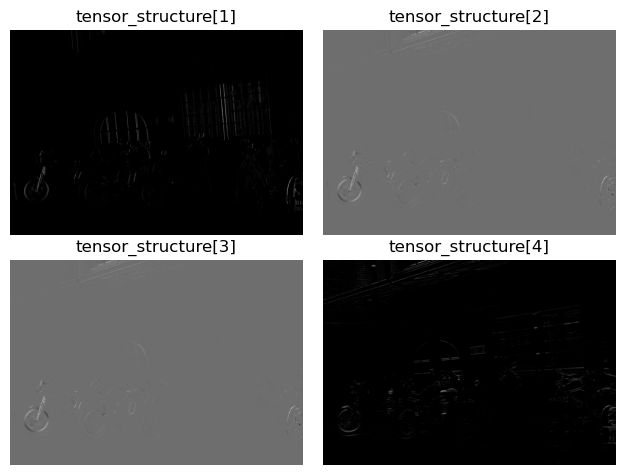

In [613]:
fig, axes = plt.subplots(2,2)
for ax in axes.flat:
    ax.set_axis_off()
plt.subplot(221), plt.imshow(tensor_structure[0,0],cmap='gray'), plt.title('tensor_structure[1]')
plt.subplot(222), plt.imshow(tensor_structure[0,1],cmap='gray'), plt.title('tensor_structure[2]')
plt.subplot(223), plt.imshow(tensor_structure[1,0],cmap='gray'), plt.title('tensor_structure[3]')
plt.subplot(224), plt.imshow(tensor_structure[1,1],cmap='gray'), plt.title('tensor_structure[4]')
plt.tight_layout() 

In [614]:
def computeFeatureMeasure(image, image_name,block_size=2, ksize=3, k=0.04, threshold=0.03,nms_window_size=500):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the gradients using Sobel operator
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)

    # Calculate the elements of the auto-correlation matrix
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # Calculate the sum of the elements of the auto-correlation matrix using a filter
    sum_xx = cv2.boxFilter(Ixx, -1, (block_size, block_size))
    sum_yy = cv2.boxFilter(Iyy, -1, (block_size, block_size))
    sum_xy = cv2.boxFilter(Ixy, -1, (block_size, block_size))

    # Calculate the determinant and trace of the auto-correlation matrix
    det = sum_xx * sum_yy - sum_xy ** 2
    trace = sum_xx + sum_yy

    # Calculate the Harris response
    harris_response = det - k * (trace ** 2)

    # Threshold the response to obtain strong corners
    harris_response_thresholded = np.zeros_like(harris_response, dtype=np.uint8)
    harris_response_thresholded[harris_response > threshold * harris_response.max()] = 255
    
    # Apply non-maximal suppression
    harris_response_nms = harris_response_thresholded.copy()
    pad_size = nms_window_size // 2
    for i in range(pad_size, harris_response_thresholded.shape[0] - pad_size):
        for j in range(pad_size, harris_response_thresholded.shape[1] - pad_size):
            if harris_response_thresholded[i, j] == 255:
                window = harris_response[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
                local_max = np.amax(window)
                if harris_response[i, j] < local_max:
                    harris_response_nms[i, j] = 0

    # Dilate the thresholded image to make the corners more visible
    harris_response_dilated = cv2.dilate(harris_response_thresholded, None)

    # Create a copy of the original image to draw the corners on
    corners_image = np.copy(image)

    # Draw the detected corners on the image
    corners_image[harris_response_dilated > 0] = [0, 0, 255]
    path=f'bikes/bike_img1/bike_{image_name}_corners.jpg'
    cv2.imwrite(path,corners_image)
    fig, ax = plt.subplots(1,1)
    ax.set_axis_off()
    plt.subplot(111), plt.imshow(corners_image), plt.title('bike_img1 Corners')
    
    return harris_response_nms

In [615]:
def FeatureMeasure2Points(harris_response_nms):
    # Find keypoints from the corner map
    keypoints = []
    for i in range(harris_response_nms.shape[0]):
        for j in range(harris_response_nms.shape[1]):
            if harris_response_nms[i, j] > 0:
                keypoints.append([j, i])  # Using [x, y] for simplicity

    return keypoints,harris_response_nms

In [616]:
def generateFeatureDescriptors(image, corners, num_bins=9):
    """
    Computes intensity invariant descriptors for corners in the input image.

    :param image: The input image.
    :param corners: A list of corner points (x, y).
    :param num_bins: The number of bins for quantizing gradient orientations.
    :return: A list of corner descriptors.
    """
    descriptors = []

    # Compute the gradient magnitudes and orientations for the whole image
    gx, gy = np.gradient(image)
    gradient_magnitudes = np.sqrt(gx**2 + gy**2)
    gradient_orientations = np.arctan2(gy, gx)

    # Pad the image to ensure windows around corners are safe
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='edge')

    # Iterate through each corner and compute the descriptor
    for corner in corners:
        x, y = corner

        # Extract a window around the corner
        window = padded_image[y:y+window_size, x:x+window_size]

        # Compute the gradient magnitudes and orientations for the window
        gx, gy = np.gradient(window)
        gradient_magnitudes_window = np.sqrt(gx**2 + gy**2)
        gradient_orientations_window = np.arctan2(gy, gx)

        # Quantize the gradient orientations into bins
        bin_width = 2 * np.pi / num_bins
        bins = np.arange(-np.pi, np.pi + bin_width, bin_width)
        digitized = np.digitize(gradient_orientations_window.flatten(), bins, right=True)

        # Compute the histogram of the quantized gradient orientations
        hist, _ = np.histogram(digitized, bins=np.arange(num_bins + 1))

        # Normalize the histogram to make the descriptor intensity invariant
        descriptor = hist / np.linalg.norm(hist)

        # Append the descriptor to the list of descriptors
        descriptors.append(descriptor)

    return descriptors


In [617]:
def draw_matching_lines(image1, image2, matched_points1, matched_points2):
    # Combine the two images side by side
    combined_image = np.hstack((image1, image2))

    # Loop through matched points and draw lines between them
    for (x1, y1), (x2, y2) in zip(matched_points1, matched_points2):
        x2 += image1.shape[1]  # Shift x-coordinate for the second image
        cv2.line(combined_image, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Draw a line between matched points

    # Display the result
    plt.imshow(combined_image)
    plt.title("Matched Key Points")
    plt.axis('off') 
    plt.show()

(<Axes: title={'center': 'bike_img1 Descriptor'}>,
 Text(0.5, 1.0, 'bike_img1 Descriptor'))

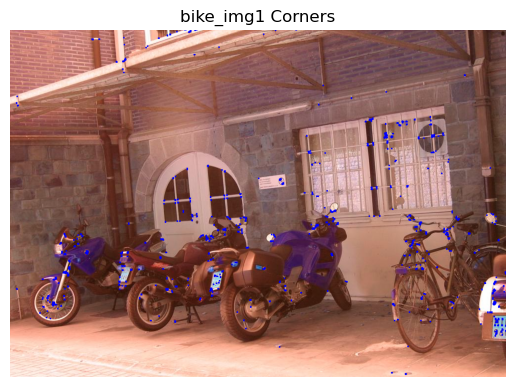

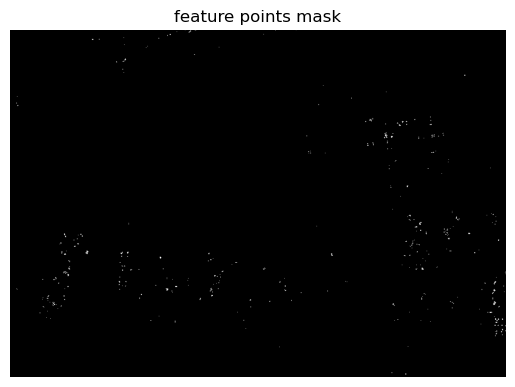

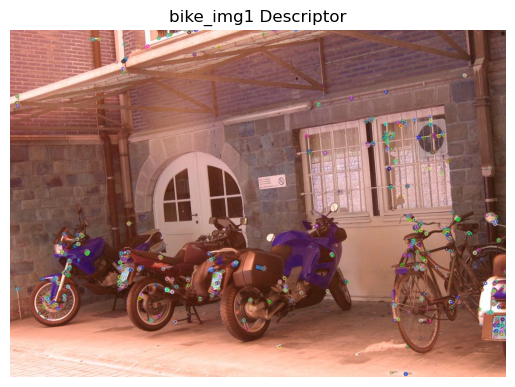

In [618]:
# Detect corners using the Harris Corner Detector
harris_response_nms1 = computeFeatureMeasure(img1,"img1")
keypoints1,mask=FeatureMeasure2Points(harris_response_nms1)

cv2.imwrite('bikes/bike_img1/bike_img1_feature_mask.jpg',mask)
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
plt.subplot(111), plt.imshow(mask,cmap='gray'), plt.title('feature points mask')
    
# Compute HOG descriptors for the detected keypoints
DList1 = generateFeatureDescriptors(img1_gray,keypoints1)

# Convert the keypoints to a list of cv2.KeyPoint objects
cv_keypoints1 = [cv2.KeyPoint(x, y, 1) for x, y in keypoints1]
DList1 = np.array(DList1)

# Display the detected keypoints on the image
img1_descriptor = cv2.drawKeypoints(img1, cv_keypoints1, None)
cv2.imwrite('bikes/bike_img1/bike_img1_descriptor.jpg',img1_descriptor)
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
plt.subplot(111), plt.imshow(img1_descriptor), plt.title('bike_img1 Descriptor')

(<Axes: title={'center': 'bike_img2 Descriptor'}>,
 Text(0.5, 1.0, 'bike_img2 Descriptor'))

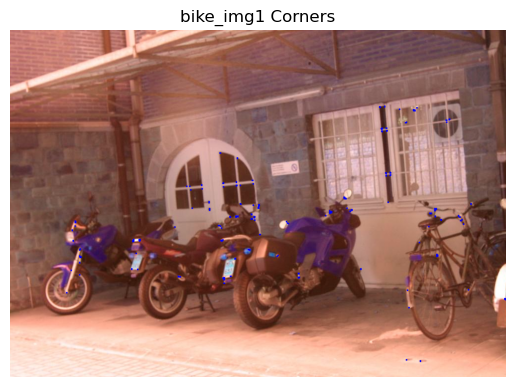

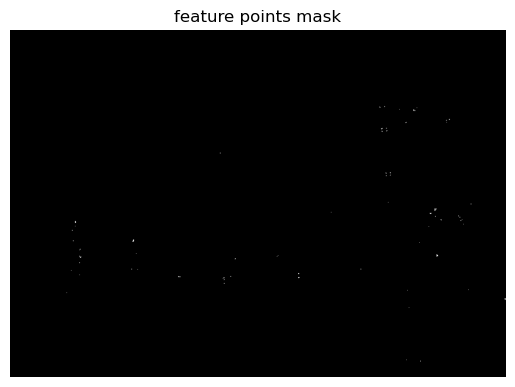

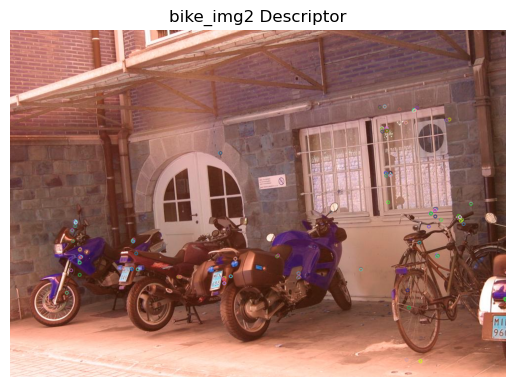

In [619]:
# Detect corners using the Harris Corner Detector
harris_response_nms2 = computeFeatureMeasure(img2,"img2")
keypoints2,mask=FeatureMeasure2Points(harris_response_nms2)

cv2.imwrite('bikes/bike_img1/bike_img2_feature_mask.jpg',mask)
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
plt.subplot(111), plt.imshow(mask,cmap='gray'), plt.title('feature points mask')
    
# Compute HOG descriptors for the detected keypoints
DList2 = generateFeatureDescriptors(img2_gray,keypoints2)


# Convert the keypoints to a list of cv2.KeyPoint objects
cv_keypoints2 = [cv2.KeyPoint(x, y, 1) for x, y in keypoints2]

DList2 = np.array(DList2)

# Display the detected keypoints on the image
img2_descriptor = cv2.drawKeypoints(img1, cv_keypoints2, None)
cv2.imwrite('bikes/bike_img1/bike_img2_descriptor.jpg',img2_descriptor)
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
plt.subplot(111), plt.imshow(img2_descriptor), plt.title('bike_img2 Descriptor')

In [620]:
def computeDescriptorDistances(Dlist1, Dlist2):
    # Calculate Euclidean distance between each pair of descriptors
    distance_matrix = np.zeros((len(Dlist1), len(Dlist2)))
    for i, descriptor1 in enumerate(descriptors1):
        for j, descriptor2 in enumerate(descriptors2):
            distance_matrix[i, j] = np.linalg.norm(descriptor1 - descriptor2)
    return distance_matrix


In [621]:
def Distance2Matches_DistThresh(keypoints1, Dlist1, keypoints2, Dlist2,Th):
    # Initialize lists to store matched key points
    matched_points1 = []
    matched_points2 = []
    x=[]
    # Loop through each key point in the first image
    for i, (x1,y1) in enumerate(keypoints1):
        # Initialize variables to store the minimum distance and index of the best match
        min_distance = Th
        best_match_index = None
        
        # Get the descriptor for the current key point in the first image
        descriptor1 = Dlist1[i]
        
        # Loop through each key point in the second image
        for j, (x2,y2) in enumerate(keypoints2):
            # Get the descriptor for the current key point in the second image
            descriptor2 = Dlist2[j]
            
            # Compute the distance between the descriptors
            distance = np.linalg.norm(descriptor1 - descriptor2)
            x.append(distance)
            # Check if the current match is better than the previous best match
            if distance < Th:
                best_match_index = j
                
        
        # Add the matched key points to the lists
        matched_points1.append((x1,y1))
        matched_points2.append((keypoints2[best_match_index]))
    x=np.array(x)
    print(np.mean(x))
    return matched_points1, matched_points2

In [622]:
def Distance2Matches_NearestMatch(keypoints1, Dlist1, keypoints2, Dlist2):
    # Initialize lists to store matched key points
    matched_points1 = []
    matched_points2 = []

    # Loop through each key point in the first image
    for i, (x1, y1) in enumerate(keypoints1):
        # Get the descriptor for the current key point in the first image
        descriptor1 = Dlist1[i]

        # Initialize variables to store the minimum distance and index of the best match
        min_distance = float('inf')
        best_match_index = None

        # Loop through each key point in the second image
        for j, (x2, y2) in enumerate(keypoints2):
            # Get the descriptor for the current key point in the second image
            descriptor2 = Dlist2[j]

            # Compute the distance between the descriptors
            distance = np.linalg.norm(descriptor1 - descriptor2)

            # Check if the distance is below the threshold
            if distance < min_distance:
                min_distance=distance
                best_match_index = j
                # Add the matched key points to the lists
        
        # Add the matched key points to the lists
        matched_points1.append((x1,y1))
        matched_points2.append((keypoints2[best_match_index]))

    return matched_points1, matched_points2

In [623]:
def Distance2Matches_NearestRatio(keypoints1, Dlist1, keypoints2, Dlist2, ratio_threshold=0.85):
    # Initialize lists to store matched key points
    matched_points1 = []
    matched_points2 = []
    
    # Loop through each key point in the first image
    for i, (x1, y1) in enumerate(keypoints1):
        # Get the descriptor for the current key point in the first image
        descriptor1 = Dlist1[i]

        # Initialize variables to store the distances to the two closest points and their indices
        closest_distances = [float('inf'), float('inf')]
        closest_indices = [-1, -1]

        # Loop through each key point in the second image
        for j, (x2, y2) in enumerate(keypoints2):
            # Get the descriptor for the current key point in the second image
            descriptor2 = Dlist2[j]

            # Compute the Euclidean distance between the descriptors
            distance = np.linalg.norm(descriptor1 - descriptor2)

            # Check if the current distance is closer than the two closest distances
            if distance < closest_distances[0]:
                closest_distances = [distance, closest_distances[0]]
                closest_indices = [j, closest_indices[0]]
            elif distance < closest_distances[1]:
                closest_distances[1] = distance
                closest_indices[1] = j

        # Compute the ratio of the two closest distances
        ratio = closest_distances[0] / closest_distances[1]
        
        # Check if the ratio is less than the threshold
        if ratio < ratio_threshold:
            # Add the matched key points to the lists
            matched_points1.append((x1, y1))
            matched_points2.append((keypoints2[closest_indices[0]]))

    return matched_points1, matched_points2

In [624]:
def draw_matching_lines(image1, image2, matched_points1, matched_points2,name):
    # Combine the two images side by side
    combined_image = np.hstack((image1, image2))
    path=f"bikes/bike_img1/matched_points_{name}.png"
    # Loop through matched points and draw lines between them
    for (x1, y1), (x2, y2) in zip(matched_points1, matched_points2):
        x2 += image1.shape[1]  # Shift x-coordinate for the second image
        cv2.line(combined_image, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Draw a line between matched points
    matched_image=combined_image.copy()
    # Display the result
    plt.imshow(combined_image)
    plt.title("Matched Key Points")
    plt.axis('off') 
    plt.savefig(path)
    plt.show()

0.3262286881672387


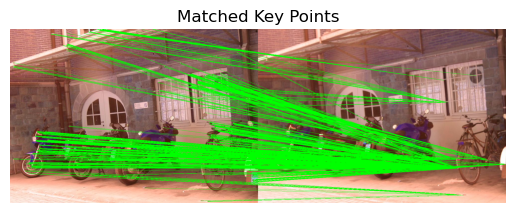

In [626]:
matched_points1_threshold, matched_points2_threshold = Distance2Matches_DistThresh(keypoints1, DList1, keypoints2, DList2,0.33)
draw_matching_lines(img1, img2, matched_points1_threshold, matched_points2_threshold,"threshold")

matched_points1_nearest, matched_points2_nearest = Distance2Matches_NearestMatch(keypoints1, DList1, keypoints2, DList2)
draw_matching_lines(img1, img2, matched_points1_nearest, matched_points2_nearest,"nearest")

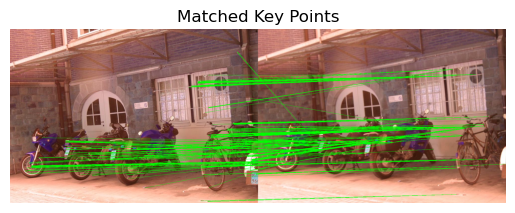

In [627]:
matched_points1_nearest_ratio, matched_points2_nearest_ratio = Distance2Matches_NearestRatio(keypoints1, DList1, keypoints2, DList2,0.95)
draw_matching_lines(img1, img2, matched_points1_nearest_ratio, matched_points2_nearest_ratio,"nearest_ratio")

In [628]:
def feature_matching_performance(matched_points1, matched_points2, transformation_matrix, k):
    true_positives = 0
    false_positives = 0
    
    for i in range(len(matched_points1)):
        # Extract matched points from the lists
        x1, y1 = matched_points1[i]
        x2, y2 = matched_points2[i]
        
        # Apply transformation matrix to the point from image 1
        estimated_point2 = np.dot(transformation_matrix, np.array([x1, y1, 1]))
        
        # Check if the points are within k pixels
        if abs(estimated_point2[0] - x2) <= k and abs(estimated_point2[1] - y2) <= k:
            true_positives += 1
        else:
            false_positives += 1
            
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    total_matches = true_positives + false_positives
    tpr = true_positives / total_matches
    fpr = false_positives / total_matches
    
    return tpr, fpr

In [629]:
def get_unique_matches(matched_points):
    unique_set = set(tuple(x) for x in matched_points)

    # Convert the set back to a list
    unique_list = [list(x) for x in unique_set]

    return unique_set

In [630]:
unique_matched_points2_threshold=get_unique_matches(matched_points2_threshold)
# print("TP:",len(unique_matched_points2_threshold)," FN:",len(DList2)-len(unique_matched_points2_threshold) ," FP:",len(DList2)-len(unique_matched_points2_threshold)," TN:",len(DList1)-len(DList2))
print("\nPerformance Based on threshold value:",feature_matching_performance(matched_points1_threshold, matched_points2_threshold, transformation_matrix, 200))
print("Total matched for threshold matching: ",len(unique_matched_points2_threshold))

unique_matched_points2_nearest=get_unique_matches(matched_points2_nearest)
print("\nPerformance Based on nearest neighbor:",feature_matching_performance(matched_points1_nearest, matched_points2_nearest, transformation_matrix, 200))
print("Total matched for nearest matching: ",len(unique_matched_points2_nearest))

unique_matched_points2_nearest_ratio=get_unique_matches(matched_points2_nearest_ratio)
print("\nPerformance Based on nearest ratio:",feature_matching_performance(matched_points1_nearest_ratio, matched_points2_nearest_ratio, transformation_matrix, 200))
print("Total matched for nearest ratio matching: ",len(unique_matched_points2_nearest_ratio))

print("Detected feature points:", len(DList2))


Performance Based on threshold value: (0.26291079812206575, 0.7370892018779343)
Total matched for threshold matching:  12

Performance Based on nearest neighbor: (0.5254415815913143, 0.4745584184086858)
Total matched for nearest matching:  2495

Performance Based on nearest ratio: (0.8837209302325582, 0.11627906976744186)
Total matched for nearest ratio matching:  29
Detected feature points: 179


In [631]:
# Convert the image to the LAB color space
lab_image = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)

# Increase the brightness by adding a constant value to the L channel
brightness_factor = 50
contrast_factor = 1.5

lab_image[:, :, 0] = cv2.add(lab_image[:, :, 0], brightness_factor)

lab_image[:, :, 0] = cv2.multiply(lab_image[:, :, 0], contrast_factor)

# Convert the image back to the BGR color space
enhanced_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2BGR)

# Save the enhanced image
cv2.imwrite('bikes/bike_img1/enhanced_image.jpg', enhanced_image)


True

(<Axes: title={'center': 'bike_img1 Descriptor'}>,
 Text(0.5, 1.0, 'bike_img1 Descriptor'))

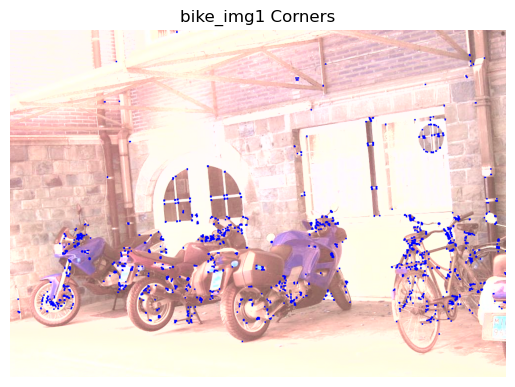

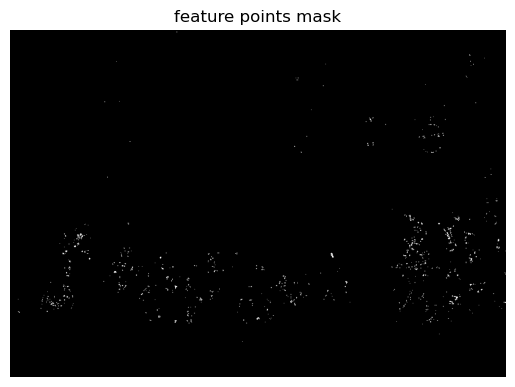

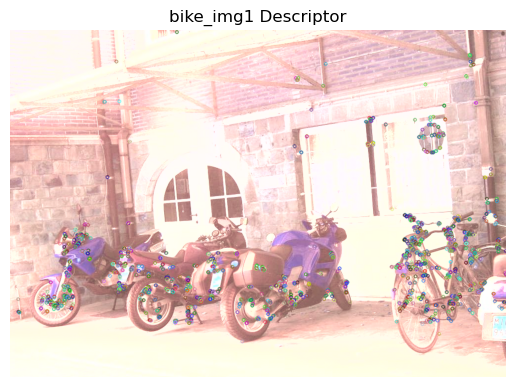

In [632]:
# Detect corners using the Harris Corner Detector
harris_response_nms_enhanced = computeFeatureMeasure(enhanced_image,"enhanced_image")
keypoints_enhanced,mask=FeatureMeasure2Points(harris_response_nms_enhanced)

cv2.imwrite('bikes/bike_img1/bike_enhanced_feature_mask.jpg',mask)
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
plt.subplot(111), plt.imshow(mask,cmap='gray'), plt.title('feature points mask')
    
# Compute HOG descriptors for the detected keypoints
DListEnhanced = generateFeatureDescriptors(img1_gray,keypoints_enhanced)

# Convert the keypoints to a list of cv2.KeyPoint objects
cv_keypoints_enhanced = [cv2.KeyPoint(x, y, 1) for x, y in keypoints_enhanced]
DListEnhanced = np.array(DListEnhanced)

# Display the detected keypoints on the image
enhanced_img_descriptor = cv2.drawKeypoints(enhanced_image, cv_keypoints_enhanced, None)
cv2.imwrite('bikes/bike_img1/bike_img_enhanced_descriptor.jpg',enhanced_img_descriptor)
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
plt.subplot(111), plt.imshow(enhanced_img_descriptor), plt.title('bike_img1 Descriptor')

0.28826289175303976


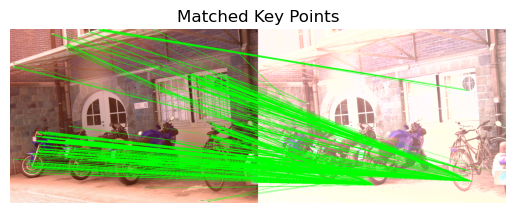

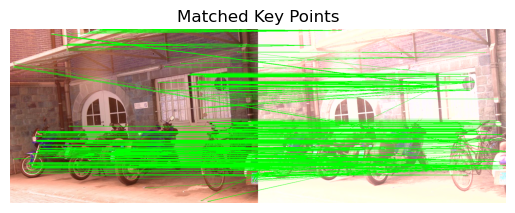

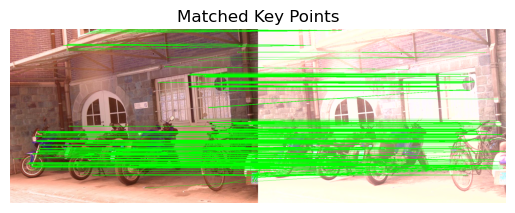

In [633]:
matched_points1_threshold, matched_points2_threshold = Distance2Matches_DistThresh(keypoints1, DList1, keypoints_enhanced, DListEnhanced,0.4650)
draw_matching_lines(img1, enhanced_image, matched_points1_threshold, matched_points2_threshold,"threshold_enhanced")

matched_points1_nearest, matched_points2_nearest = Distance2Matches_NearestMatch(keypoints1, DList1, keypoints_enhanced, DListEnhanced)
draw_matching_lines(img1, enhanced_image, matched_points1_nearest, matched_points2_nearest,"nearest_enhanced")

matched_points1_nearest_ratio, matched_points2_nearest_ratio = Distance2Matches_NearestRatio(keypoints1, DList1, keypoints_enhanced, DListEnhanced,0.95)
draw_matching_lines(img1, enhanced_image, matched_points1_nearest_ratio, matched_points2_nearest_ratio,"nearest_ratio_enhanced")

In [634]:
print(len(DListEnhanced))
unique_matched_points2_threshold=get_unique_matches(matched_points2_threshold)
# print("TP:",len(unique_matched_points2_threshold)," FN:",len(DList2)-len(unique_matched_points2_threshold) ," FP:",len(DList2)-len(unique_matched_points2_threshold)," TN:",len(DList1)-len(DList2))
print("\nPerformance Based on threshold value:",feature_matching_performance(matched_points1_threshold, matched_points2_threshold, transformation_matrix, 200))
print("Total matched for threshold matching: ",len(unique_matched_points2_threshold))

unique_matched_points2_nearest=get_unique_matches(matched_points2_nearest)
print("\nPerformance Based on nearest neighbor:",feature_matching_performance(matched_points1_nearest, matched_points2_nearest, transformation_matrix, 200))
print("Total matched for nearest matching: ",len(unique_matched_points2_nearest))

unique_matched_points2_nearest_ratio=get_unique_matches(matched_points2_nearest_ratio)
print("\nPerformance Based on nearest ratio:",feature_matching_performance(matched_points1_nearest_ratio, matched_points2_nearest_ratio, transformation_matrix, 200))
print("Total matched for nearest ratio matching: ",len(unique_matched_points2_nearest_ratio))

2133

Performance Based on threshold value: (0.10610328638497653, 0.8938967136150234)
Total matched for threshold matching:  22

Performance Based on nearest neighbor: (0.9492957746478873, 0.05070422535211268)
Total matched for nearest matching:  517

Performance Based on nearest ratio: (0.973170731707317, 0.026829268292682926)
Total matched for nearest ratio matching:  481
